In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets,transforms,models
from torchvision.transforms.transforms import ToPILImage
import os
import cv2
import torch.optim as optim
from PIL import ImageFile,Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from torch.autograd import Variable
from torch.nn.modules.dropout import Dropout
import itertools
from google.colab.patches import cv2_imshow
from torchsummary import summary

In [2]:
resize = (224,224)
batch_size = 32

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)


In [3]:
classes = ['COVID','Normal','Pneu-Bac','Pneu-Viral']

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


**Image Transform**

In [11]:
img_transform = {
    'train':transforms.Compose([
                                transforms.Resize(resize),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean,std)
    ]),
    'val':transforms.Compose([
                              transforms.Resize(resize),
                              transforms.CenterCrop(resize),
                              transforms.ToTensor(),
                              transforms.Normalize(mean,std)
    ]),
    'test':transforms.Compose([
                               transforms.Resize(resize),
                               transforms.ToTensor(),
                               transforms.Normalize(mean,std)
    ])
}

**Datasets**

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/COVID-LVTN/split_data/train'
val_path = '/content/drive/MyDrive/Colab Notebooks/COVID-LVTN/split_data/valid'
test_path = '/content/drive/MyDrive/Colab Notebooks/COVID-LVTN/split_data/test'

In [ ]:
train_count = len(glob.glob(train_path+'/**/*.jpg'))
val_count = len(glob.glob(val_path+'/**/*.jpg'))
test_count = len(glob.glob(val_path+'/**/*.jpg'))
print(train_count,val_count,test_count)

5526 1841 1841


In [ ]:
#datasets
train_file = datasets.ImageFolder(train_path,transform=img_transform['train'])
val_file = datasets.ImageFolder(val_path,transform=img_transform['val'])
test_file = datasets.ImageFolder(test_path,transform=img_transform['test'])

**Dataloader**

In [ ]:
loader = {
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'val':torch.utils.data.DataLoader(val_file,batch_size,shuffle=False),
    'test':torch.utils.data.DataLoader(test_file,batch_size,shuffle=False)
}

**Load checkpoint model**

In [6]:
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/COVID-LVTN/checkpoint_effb0_3.pt',map_location='cpu')
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(1280,4)
for param in model.parameters():
  param.requires_grad = False
model.load_state_dict(checkpoint['model_state_dict']);
model.eval()

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

**Loss & Optimizer**

In [ ]:
#loss
criterior = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.Adam(model.parameters(),lr=0.001)

**Test model**

In [ ]:
model.eval()
test_loss = 0.0
test_acc = 0.0
preds = []
targets = []

for inputs,labels in tqdm(loader['test']):
  outputs = model(inputs)
  loss = criterior(outputs,labels)
  test_loss += loss.cpu().data*inputs.size(0)

  _,prediction = torch.max(outputs.data,1)
  preds.append(prediction)
  targets.append(labels)

  test_acc += torch.sum(prediction==labels.data)

test_acc = test_acc/test_count

100%|██████████| 58/58 [11:02<00:00, 11.42s/it]


In [ ]:
#converting the tensor object to a list for metric functions
preds2, targets2 = [],[]

for i in preds:
  for j in range(len(i)):
    preds2.append(i.cpu().numpy()[j])
for i in targets:
  for j in range(len(i)):
    targets2.append(i.cpu().numpy()[j])

In [ ]:
#Computing accuracy
acc = accuracy_score(targets2,preds2)
print('Accuracy:',acc)

Accuracy: 0.9071156979902227


**Confusion matrix**

In [ ]:
cm = confusion_matrix(targets2,preds2)
print(cm)

[[252   3   1   0]
 [  0 645   0   9]
 [  2   6 503  89]
 [  0   0  61 270]]


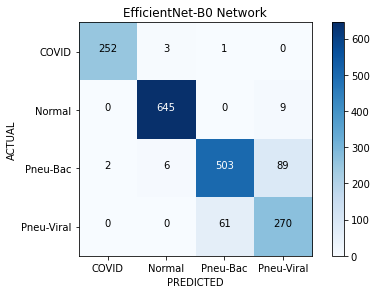

In [ ]:
from numpy.core.fromnumeric import size
def plot_confusion_matrix(cm, classes, normalize=False, title='EfficientNet-B0 Network', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('ACTUAL')
    plt.xlabel('PREDICTED')

plot_confusion_matrix(cm,classes)

**Classification report**

In [ ]:
#classification report
print('Classification Report\n---------------------')
print(classification_report(targets2,preds2))

Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       256
           1       0.99      0.99      0.99       654
           2       0.89      0.84      0.86       600
           3       0.73      0.82      0.77       331

    accuracy                           0.91      1841
   macro avg       0.90      0.91      0.90      1841
weighted avg       0.91      0.91      0.91      1841



**Loss & Accuracy plot**

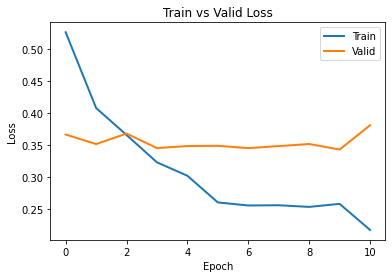

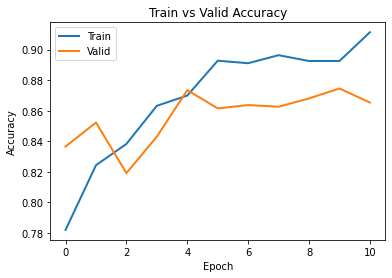

In [ ]:
#Load checkpoint
train_losses = checkpoint['train_losses']
train_accu = checkpoint['train_accu']
val_losses = checkpoint['val_losses']
val_accu = checkpoint['val_accu']

#Plot loss
plt.plot(train_losses[:11],linewidth=2)
plt.plot(val_losses[:11],linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.show()

#Plot accuracy
plt.plot(train_accu[:11],linewidth=2)
plt.plot(val_accu[:11],linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.show()

In [ ]:
max_accu = max(val_accu)
idx = val_accu.index(max_accu)
print(idx,max_accu,val_losses[idx])

9 tensor(0.8745) tensor(0.3432)


**Prediction image**

In [7]:
def predicton(img_path,transformer):
  #load image
  img = Image.open(img_path).convert("RGB")
  plt.imshow(img)
  plt.show()

  img_tensor = transformer(img)
  img_tensor = img_tensor.unsqueeze_(0)
 
  #Predict img 
  output = model(img_tensor)
  _,prediction=torch.max(output.data,1)
  label_pred = classes[prediction]
  
  return label_pred

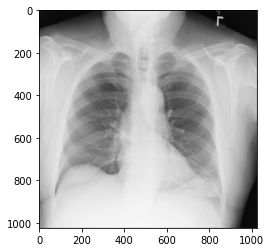

		 COVID


In [9]:
img_path = '/content/drive/MyDrive/Colab Notebooks/COVID19/data/png/normal/00000018_000.png'
label_pred = predicton(img_path,img_transform['test'])
print('\t\t',label_pred)

In [14]:
png_file = '/content/drive/MyDrive/Colab Notebooks/COVID19/data/png/normal/00000018_000.png'
# eval png
png_image = Image.open(png_file)
png_image = png_image.convert("RGB")
png_image = img_transform['test'](png_image)
png_image = torch.unsqueeze(png_image, 0)
output = model(png_image)
print(output)

# eval frame
imgg = cv2.imread(png_file)
vid_array = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)
vid_image = Image.fromarray(imgg)
vid_image = img_transform['test'](vid_image)
vid_image = torch.unsqueeze(vid_image, 0)
output = model(vid_image)
print(output)

tensor([[ 9.6646,  2.8129, -2.0899, -2.4478]])
tensor([[ 9.6646,  2.8129, -2.0899, -2.4478]])


In [ ]:
summary(model,(3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [ ]:
cd "/content/drive/MyDrive/Colab Notebooks/COVID-LVTN/split_data/test"

/content/drive/MyDrive/Colab Notebooks/COVID-LVTN/split_data/test


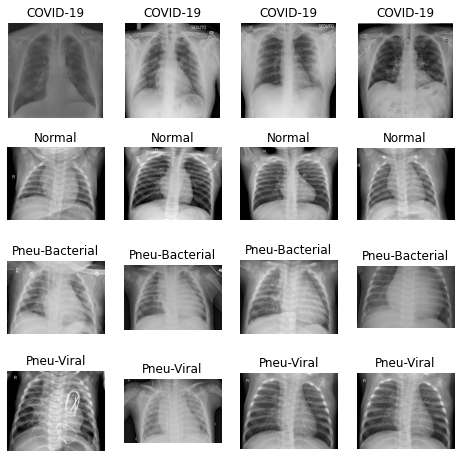

In [ ]:
Image1 = cv2.imread('COVID-19/COVID-19 (1034).jpg')
Image2 = cv2.imread('COVID-19/COVID-19 (1035).jpg')
Image3 = cv2.imread('COVID-19/COVID-19 (1036).jpg')
Image4 = cv2.imread('COVID-19/COVID-19 (1037).jpg')

Image5 = cv2.imread('Normal/Normal (1).jpg')
Image6 = cv2.imread('Normal/Normal (10).jpg')
Image7 = cv2.imread('Normal/Normal (100).jpg')
Image8 = cv2.imread('Normal/Normal (1000).jpg')

Image9 = cv2.imread('Pneumonia-Bacterial/Pneumonia-Bacterial (1).jpg')
Image10 = cv2.imread('Pneumonia-Bacterial/Pneumonia-Bacterial (1360).jpg')
Image11= cv2.imread('Pneumonia-Bacterial/Pneumonia-Bacterial (1361).jpg')
Image12 = cv2.imread('Pneumonia-Bacterial/Pneumonia-Bacterial (1362).jpg')

Image13 = cv2.imread('Pneumonia-Viral/Pneumonia-Viral (1291).jpg')
Image14 = cv2.imread('Pneumonia-Viral/Pneumonia-Viral (1292).jpg')
Image15 = cv2.imread('Pneumonia-Viral/Pneumonia-Viral (1293).jpg')
Image16 = cv2.imread('Pneumonia-Viral/Pneumonia-Viral (1293).jpg')

images = [Image1,Image2,Image3,Image4,Image5,Image6,Image7,Image8,Image9,Image10,Image11,Image12,Image13,Image14,Image15,Image16]
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")
    if (i<=4):
      plt.title("COVID-19")
    elif (4<i<=8):
      plt.title("Normal")
    elif (8<i<=12):
      plt.title("Pneu-Bacterial")
    else:
      plt.title("Pneu-Viral")

plt.show()